In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import lines
import pandas as pd
import scipy.stats as stats

%matplotlib inline

In [2]:
df = pd.read_pickle("../run/Taa/df-grouped-sim.pkl")
df = df[(df.model == 'propwaves') & (df.noise == 1)]

In [3]:
import itertools
def add_panel_letters(fig, axes=None, fontsize=30, xpos=-0.04, ypos=1.05):
    labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    if axes is None:
        axes = fig.get_axes()

    if type(xpos) == float:
        xpos = itertools.repeat(xpos)
    if type(ypos) == float:
        ypos = itertools.repeat(ypos)

    for i, (ax, x, y) in enumerate(zip(axes, xpos, ypos)):
        ax.text(x, y, labels[i],
                transform=ax.transAxes, size=fontsize, weight='bold')

In [4]:
def add_params(df):
    df['uslow'] = 0.
    df['ufast'] = 0.
    df['patch_size'] = 0.
    df['simfreq'] = 0.

    model = 'propwaves'
    noise = 1
    for sid in range(1, 51):
        subject = f"id{sid:03d}"
        print(subject, end=" ", flush=True)
        conf = pd.read_pickle(f"../run/Taa/simulations/configs_{subject}_{model}_{noise}.pkl")
        for i, row in conf.iterrows():
            mask = (df.subject == subject) & (df.rec == i)
            df.loc[mask, ['uslow', 'ufast', 'patch_size', 'simfreq']] = (row.uslow, np.abs(row.ufast),
                                                                         row.patch_size, row.freq)
            
add_params(df)
df['lamb'] = df.ufast / df.simfreq

id001 id002 id003 id004 id005 id006 id007 id008 id009 id010 id011 id012 id013 id014 id015 id016 id017 id018 id019 id020 id021 id022 id023 id024 id025 id026 id027 id028 id029 id030 id031 id032 id033 id034 id035 id036 id037 id038 id039 id040 id041 id042 id043 id044 id045 id046 id047 id048 id049 id050 

In [5]:
params = ['uslow', 'patch_size', 'ufast', 'simfreq']
param_lims = [(0.5, 4.0), (400, 2500), (100., 500.), (4, 13)]
param_names = ['Spread\nvelocity', 'Patch size', 'Wave\nvelocity', 'Frequency']

features = ['tdur', 'tfr_slope', 'tfr_r2', 'pca_ve1', 'pca_ve2ac']
feature_names = ['Duration', 'Slope', 'R2', 'PCA VE1', 'PCA VE2']

def get_param_effects(df):
    param_effects = np.zeros((len(features), len(params)))
    ndetected = np.zeros(len(params))

    for j, param in enumerate(params):
        w = param_lims[j][1] - param_lims[j][0]
        
        mask = df[param] > (param_lims[j][0] + param_lims[j][1])/2.
        dfu, dfl = df[mask], df[~mask]
        
        ndetected[j] = (df[param].mean() - (param_lims[j][1] + param_lims[j][0])/2) / w
        for i, feature in enumerate(features):
            slope, _, _, _, _ = stats.linregress(df[param], df[feature])
            param_effects[i, j] = w * slope / df[feature].std()            
        
           
    return ndetected, param_effects
        
ndetected, param_effects = get_param_effects(df)

In [6]:
def get_percentiles(df, param, lim, nbins, features):
    bins = np.linspace(lim[0], lim[1], nbins + 1)
    bincenters = (bins[1:] + bins[:-1])/2

    p05 = {f: np.zeros(nbins) for f in features}
    avg = {f: np.zeros(nbins) for f in features}
    p95 = {f: np.zeros(nbins) for f in features}

    for i in range(nbins):
        dff = df[(df[param] >= bins[i]) & (df[param] < bins[i+1])]

        for feature in features:
            p05[feature][i] = np.percentile(dff[feature], 5)
            avg[feature][i] = np.mean(dff[feature])
            p95[feature][i] = np.percentile(dff[feature], 95)
            
    return bincenters, p05, avg, p95

bins_us, p05_us, avg_us, p95_us = get_percentiles(df, 'uslow', (0.5, 4), 10, ['tfr_slope', 'tdur'])
bins_wl, p05_wl, avg_wl, p95_wl = get_percentiles(df, 'lamb', (df.lamb.min(), df.lamb.max()),
                                                  10, ['pca_ve1', 'pca_ve2ac'])

In [7]:
def sweep2d(df, param1, param2, op, feature):
    par1, lim1, nbins1 = param1
    par2, lim2, nbins2 = param2
    
    bins1 = np.linspace(lim1[0], lim1[1], nbins1+1)
    bins2 = np.linspace(lim2[0], lim2[1], nbins2+1)
        
    res = np.zeros((nbins1, nbins2))

    for i in range(nbins1):
        for j in range(nbins2):
            dff = df[(df[par1] >= bins1[i]) & (df[par1] < bins1[i+1]) & (df[par2] >= bins2[j]) & (df[par2] < bins2[j+1])]
            
            if op == 'mean':
                res[i, j] = np.mean(dff[feature])
            elif op == 'count':
                res[i, j] = len(dff)
                
    return res, bins1, bins2

param1 = ('simfreq', (4, 13), 5)
param2 = ('ufast', (100, 500), 5)

fu_pca1, _, _ = sweep2d(df, param1, param2 , 'mean', 'pca_ve1')
fu_pca2, _, _ = sweep2d(df, param1, param2, 'mean', 'pca_ve2ac')
fu_counts, bins_f, bins_uf = sweep2d(df, param1, param2, 'count', None)

(0.0, 1.0, 0.0, 1.0)

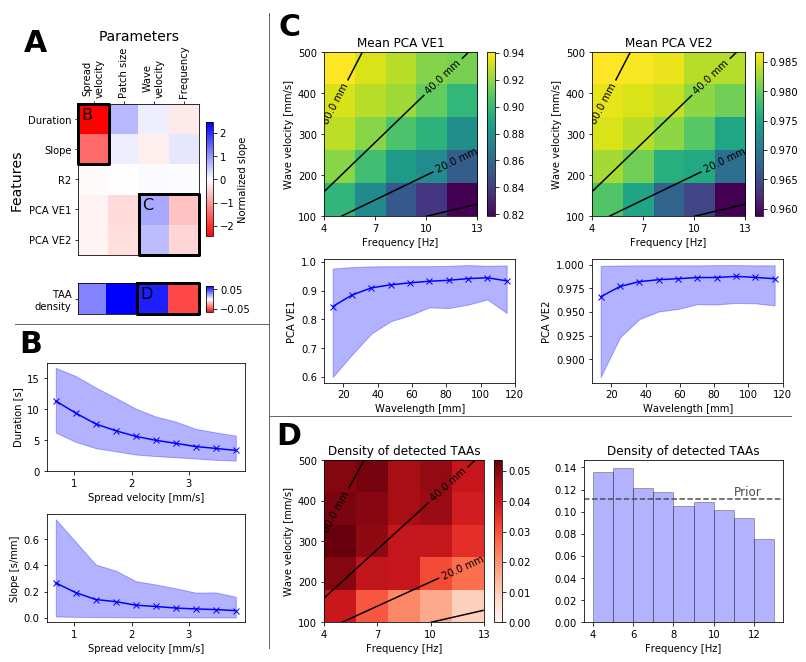

In [8]:
fig = plt.figure(figsize=(11, 9))
labeled_axes = []


# Panel A: Parameter effects ---------------------------------------------
gs1 = fig.add_gridspec(nrows=2, ncols=1, left=0.09, right=0.28, bottom=0.52, top=0.88,
                       hspace=0.05, height_ratios=[5, 1])

ax0 = fig.add_subplot(gs1[0, 0])
plt.imshow(param_effects, cmap='bwr_r', vmin=-np.max(np.abs(param_effects)), vmax=np.max(np.abs(param_effects)))
plt.colorbar(aspect=18, shrink=0.6, label="Normalized slope")
plt.xticks(np.r_[:len(param_names)], param_names, rotation='vertical')
plt.yticks(np.r_[:len(feature_names)], feature_names)
plt.xlim(-0.5, len(params) - 0.5)
plt.ylim(len(features) - 0.5, -0.5)
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("Features", fontsize=14)
ax0.xaxis.tick_top()
ax0.xaxis.set_label_position('top') 
labeled_axes.append(ax0)

ax1 = fig.add_subplot(gs1[1, 0])
plt.imshow(ndetected[None, :], cmap='bwr_r', vmin=-np.max(np.abs(ndetected)), vmax=np.max(np.abs(ndetected)))
plt.yticks([0], ['TAA\ndensity'])
plt.xticks([])
plt.xlim(-0.4, len(params) - 0.5)
plt.ylim(0.5, -0.5)
plt.colorbar(aspect=4, shrink=0.7, ticks=[-0.05, 0.05])


# Panel B: Effect of u_slow -----------------------------------------------
gs2 = fig.add_gridspec(nrows=2, ncols=1, left=0.05, right=0.3, bottom=0.05, top=0.45, hspace=0.4)
for i, (feature, feature_name) in enumerate(zip(['tdur', 'tfr_slope'], ['Duration [s]', 'Slope [s/mm]'])):
    ax = fig.add_subplot(gs2[i, 0])
    plt.plot(bins_us, avg_us[feature], 'bx-')
    plt.fill_between(bins_us, p05_us[feature], p95_us[feature], color='b', alpha=0.3)
    plt.xlabel("Spread velocity [mm/s]")
    plt.ylabel(feature_name)
    if feature == 'tdur':
        plt.ylim(bottom=0.)
    
    if i == 0:
        labeled_axes.append(ax)
    
    
# Panel C: Effect of freq and u_fast ---------------------------------------
gs3 = fig.add_gridspec(nrows=2, ncols=2, left=0.4, right=0.98, bottom=0.42, top=0.93,
                       wspace=0.4, hspace=0.3, height_ratios=[4,3])

for i, (feature, feature_name, avg) in enumerate(zip(['pca_ve1', 'pca_ve2ac'],
                                                     ['PCA VE1', 'PCA VE2'],
                                                     [fu_pca1, fu_pca2])):
    if i == 0:
        ax = fig.add_subplot(gs3[0, i])
        labeled_axes.append(ax)
    else:
        ax = fig.add_subplot(gs3[0, i], sharex=ax, sharey=ax)
        
    plt.title(f"Mean {feature_name}")
    plt.imshow(avg.T, origin='lower',  # vmin=0.85, vmax=0.99,
               extent=[bins_f[0], bins_f[-1], bins_uf[0], bins_uf[-1]], aspect='auto')
    plt.colorbar()
    plt.xlabel("Frequency [Hz]");
    plt.ylabel("Wave velocity [mm/s]");
    plt.xticks([4, 7, 10, 13]); plt.yticks([100, 200, 300, 400, 500])
    

    freqs, ufasts = np.meshgrid(np.linspace(bins_f[0], bins_f[-1], 100), np.linspace(bins_uf[0], bins_uf[-1], 100))
    lamb = ufasts / freqs
    contour = ax.contour(freqs, ufasts, lamb, [10, 20, 40, 80, 160], colors='k', zorder=5)
    ax.clabel(contour, [20, 40, 80], inline=True, fontsize=10, fmt='%.1f mm')
    
    fig.add_subplot(gs3[1, i])
    plt.plot(bins_wl, avg_wl[feature], 'bx-')
    plt.fill_between(bins_wl, p05_wl[feature], p95_wl[feature], color='b', alpha=0.3)
    plt.xlabel("Wavelength [mm]")
    plt.ylabel(feature_name)
    # plt.ylim([0.6, 1.03])
    
# Panel D: Effect of freq and u_fast on 
gs4 = fig.add_gridspec(nrows=1, ncols=2, left=0.4, right=0.98, bottom=0.05, top=0.3, wspace=0.3)
ax = fig.add_subplot(gs4[0, 0])
plt.title("Density of detected TAAs")
plt.imshow(fu_counts.T/np.sum(fu_counts), origin='lower',
           vmin=0, cmap='Reds',
           extent=[bins_f[0], bins_f[-1], bins_uf[0], bins_uf[-1]], aspect='auto')
plt.colorbar()
plt.xlabel("Frequency [Hz]"); 
plt.ylabel("Wave velocity [mm/s]");
plt.xticks([4, 7, 10, 13]); plt.yticks([100, 200, 300, 400, 500])

contour = ax.contour(freqs, ufasts, lamb, [10, 20, 40, 80, 160], colors='k', zorder=5)
ax.clabel(contour, [20, 40, 80], inline=True, fontsize=10, fmt='%.1f mm')
labeled_axes.append(ax)

ax = fig.add_subplot(gs4[0, 1])
plt.title("Density of detected TAAs")
plt.hist(df.simfreq, bins=np.linspace(4, 13, 10), density=True, ec='k', color='b', alpha=0.3)
plt.xlabel("Frequency [Hz]")
plt.axhline(1./(13. - 4.), color='0.3', ls='--')
plt.text(11, 0.112, 'Prior', ha='left', va='bottom', color='0.3', fontsize=12)
    

# ETC
add_panel_letters(fig, labeled_axes, xpos=[-0.45, -0.14, -0.3, -0.3], ypos=[1.35, 1.1, 1.1, 1.1])

def highlight(ax, x0, x1, y0, y1, label):
    ax.text(x0-0.4, y0-0.4, label, color='k', fontsize=16, ha='left', va='top')
    ax.plot([x0-0.5, x1-0.5, x1-0.5, x0-0.5, x0-0.5], [y0-0.5, y0-0.5, y1-0.5, y1-0.5, y0-0.5],
            color='k', clip_on=False, lw=3)
    
highlight(ax0, 0, 1, 0, 2, 'B')
highlight(ax0, 2, 4, 3, 5, 'C')
highlight(ax1, 2, 4, 0, 1, 'D')

axbg = plt.axes([0,0,1,1])
axbg.patch.set_alpha(0.0)
axbg.add_line(lines.Line2D([0.33, 0.33], [0.01, 0.99], lw=1., color='0.4'))
axbg.add_line(lines.Line2D([0.01, 0.33], [0.51, 0.51], lw=1., color='0.4'))
axbg.add_line(lines.Line2D([0.33, 0.99], [0.368, 0.368], lw=1., color='0.4'))
plt.axis('off')
    
# plt.savefig("figs/param-effects.pdf")